# 1. Method and preperation

#### 1.1 Load data

Load the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

sns.set_theme()

# URLs of the raw CSV files
urls = [
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2018may.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2019aug.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2020dec.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2021dec.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2022jun.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2022dec.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2023may.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2023jun.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2023dec.csv',
    'https://raw.githubusercontent.com/Glymse/Project02445-statisticalEvaluationofLLM/master/Data/2024may.csv',
]

# Read and stack all CSV files
df_list = [pd.read_csv(url) for url in urls]
LLMData = pd.concat(df_list, ignore_index=True)
df = pd.DataFrame(LLMData)

# Pilot study dataset
df_pilot = df[df["set"] == "2024may"]

df

,set,question,exercise,topic,chatgpt,copilot,gemini,answer
0,2018may,1,1,5,1,4,1,4
1,2018may,2,1,5,4,2,1,5
2,2018may,3,1,5,3,1,3,2
3,2018may,4,1,5,3,3,3,3
4,2018may,5,2,2,1,1,2,1
...,...,...,...,...,...,...,...,...
295,2024may,26,13,7,2,2,2,4
296,2024may,27,13,7,2,2,2,2
297,2024may,28,14,8,4,4,5,4
298,2024may,29,14,8,5,0,0,5


#### 1.2 Sample size

In [2]:
# Binarization of answers
preds_chatgpt = (df_pilot['chatgpt'] == df_pilot['answer'])
preds_copilot = (df_pilot['copilot'] == df_pilot['answer'])
preds_gemini = (df_pilot['gemini'] == df_pilot['answer'])

# Number of correct answers (obs. in category)
x_chatgpt = preds_chatgpt.sum()
x_copilot = preds_copilot.sum()
x_gemini = preds_gemini.sum()

# Size of pilot study (number of total questions)
n_pilot = len(df_pilot)

# Proportions
p_chatgpt = x_chatgpt/n_pilot
p_copilot = x_copilot/n_pilot
p_gemini = x_gemini/n_pilot

# Parameters
alpha = 0.05
power = 0.80

# Calculate critical values
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(power)

# Chatgpt vs copilot
p_hat1 = (x_chatgpt + x_copilot)/(n_pilot + n_pilot)
n1 = (2 * p_hat1 * (1-p_hat1) * (z_beta + z_alpha)**2)/(p_chatgpt - p_copilot)**2

# Chatgpt vs gemini
p_hat2 = (x_chatgpt + x_gemini)/(n_pilot + n_pilot)
n2 = (2 * p_hat2 * (1-p_hat2) * (z_beta + z_alpha)**2)/(p_chatgpt - p_gemini)**2

# Copilot vs gemini
p_hat3 = (x_copilot + x_gemini)/(n_pilot + n_pilot)
n3 = (2 * p_hat3 * (1-p_hat3) * (z_beta + z_alpha)**2)/(p_copilot - p_gemini)**2

# Max sample size
n_max = int(np.ceil(np.max([n1, n2, n3])))

print("Max sample size:", n_max)

Max sample size: 295


# 2. Statistical analysis

### 2.1 Summary statistics

#### Metric table

In [3]:
correct = pd.DataFrame()
# Calculate correctness for each model

correct['chatgpt_correct'] = (LLMData['chatgpt'] == LLMData['answer']).astype(int)
correct['copilot_correct'] = (LLMData['copilot'] == LLMData['answer']).astype(int)
correct['gemini_correct'] = (LLMData['gemini'] == LLMData['answer']).astype(int)

correct

,chatgpt_correct,copilot_correct,gemini_correct
0,0,1,0
1,0,0,0
2,0,0,0
3,1,1,1
4,1,1,0
...,...,...,...
295,0,0,0
296,1,1,1
297,1,1,0
298,1,0,0


#### Proportions

In [4]:
# Number of correct answers in pilot study (obs. in category)
x_chatgpt = (df_pilot['chatgpt'] == df_pilot['answer']).sum()
x_copilot = (df_pilot['copilot'] == df_pilot['answer']).sum()
x_gemini = (df_pilot['gemini'] == df_pilot['answer']).sum()

# Size of pilot study (number of total questions)
n_pilot = len(df_pilot)

# Proportions
p_chatgpt, p_copilot, p_gemini = x_chatgpt/n_pilot, x_copilot/n_pilot, x_gemini/n_pilot

p_chatgpt, p_copilot, p_gemini

(0.7, 0.8, 0.3333333333333333)

#### Shapiro-Wilk Test (for normality assumption)

In [5]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each group
stat_chatgpt, p_chatgpt = shapiro(preds_chatgpt.astype(int))
stat_copilot, p_copilot = shapiro(preds_copilot.astype(int))
stat_gemini, p_gemini = shapiro(preds_gemini.astype(int))

print(f"Shapiro-Wilk test for ChatGPT: Statistics={stat_chatgpt}, p-value={p_chatgpt}")
print(f"Shapiro-Wilk test for Copilot: Statistics={stat_copilot}, p-value={p_copilot}")
print(f"Shapiro-Wilk test for Gemini: Statistics={stat_gemini}, p-value={p_gemini}")

Shapiro-Wilk test for ChatGPT: Statistics=0.5774388250536482, p-value=3.9143941396873556e-08
Shapiro-Wilk test for Copilot: Statistics=0.4921604158131566, p-value=4.432146480631244e-09
Shapiro-Wilk test for Gemini: Statistics=0.5966272958469627, p-value=6.640075557543391e-08


#### Bar plot of model-accuracy

C:\Users\jonas\AppData\Local\Temp/ipykernel_51420/722737399.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=correct_df, palette='Set2')


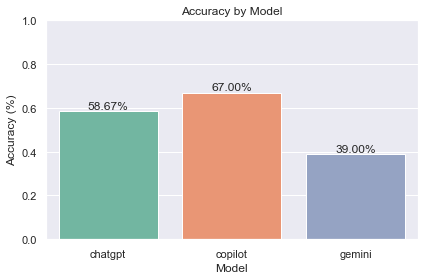

In [6]:
# Initialize counts
correct_counts = {'chatgpt': 0, 'copilot': 0, 'gemini': 0}

# Count the number of correct answers for each model
for index, row in df.iterrows():
    if row['chatgpt'] == row['answer']:
        correct_counts['chatgpt'] += 1
    if row['copilot'] == row['answer']:
        correct_counts['copilot'] += 1
    if row['gemini'] == row['answer']:
        correct_counts['gemini'] += 1

# Convert the counts to a DataFrame for plotting
correct_df = pd.DataFrame(list(correct_counts.items()), columns=['Model', 'Correct'])

# Calculate accuracy
correct_df['Accuracy'] = correct_df['Correct'] / len(df)

# Plot using Seaborn with Set2 palette
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Accuracy', data=correct_df, palette='Set2')

# Annotate each bar with the accuracy percentage
for index, row in correct_df.iterrows():
    plt.text(index, row['Accuracy'], f'{row["Accuracy"]*100:.2f}%', ha='center', va='bottom', fontsize=12)

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')  # Change ylabel to indicate percentage
plt.title('Accuracy by Model')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1
plt.tight_layout()
plt.savefig("model-mean-accuracies.svg")

# Display the plot
plt.show()

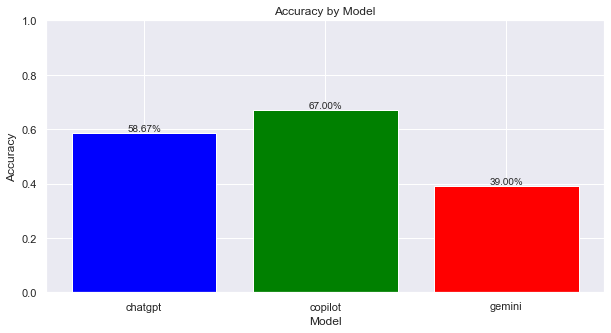

In [7]:
import pandas as pd
import matplotlib.pyplot as plt




# Initialize counts
correct_counts = {'chatgpt': 0, 'copilot': 0, 'gemini': 0}

# Count the number of correct answers for each model
for index, row in df.iterrows():
    if row['chatgpt'] == row['answer']:
        correct_counts['chatgpt'] += 1
    if row['copilot'] == row['answer']:
        correct_counts['copilot'] += 1
    if row['gemini'] == row['answer']:
        correct_counts['gemini'] += 1

# Convert the counts to a DataFrame for plotting
correct_df = pd.DataFrame(list(correct_counts.items()), columns=['Model', 'Correct'])

# Calculate accuracy
correct_df['Accuracy'] = correct_df['Correct'] / 300

# Plot the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(correct_df['Model'], correct_df['Accuracy'], color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1

# Annotate each bar with the accuracy
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom')

# Display the plot
plt.show()


#### Bar plot of model-set-accuracy

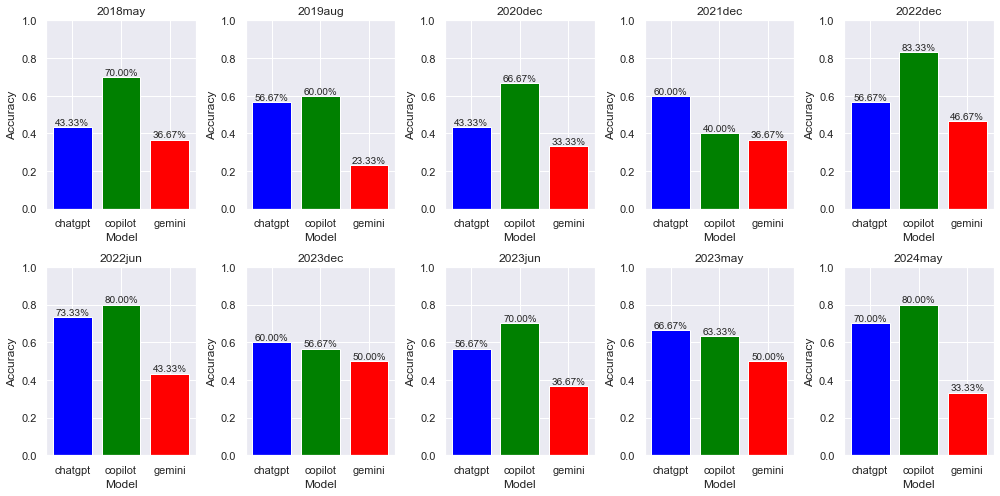

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming LLMData is already defined
df = pd.DataFrame(LLMData)

# Create a 5x2 subplot grid
fig, axes = plt.subplots(2, 5, figsize=(14, 7))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Group by 'set' and plot each group
for ax, (set_name, group) in zip(axes, df.groupby('set')):
    # Initialize counts
    correct_counts = {'chatgpt': 0, 'copilot': 0, 'gemini': 0}

    # Count the number of correct answers for each model
    for index, row in group.iterrows():
        if row['chatgpt'] == row['answer']:
            correct_counts['chatgpt'] += 1
        if row['copilot'] == row['answer']:
            correct_counts['copilot'] += 1
        if row['gemini'] == row['answer']:
            correct_counts['gemini'] += 1

    # Convert the counts to a DataFrame for plotting
    correct_df = pd.DataFrame(list(correct_counts.items()), columns=['Model', 'Correct'])

    # Calculate accuracy
    correct_df['Accuracy'] = correct_df['Correct'] / 30

    # Plot the bar plot with accuracy
    bars = ax.bar(correct_df['Model'], correct_df['Accuracy'], color=['blue', 'green', 'red'])
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.set_title(f'{set_name}')

    # Annotate each bar with the accuracy
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom')

# Remove any unused subplots
for i in range(len(df['set'].unique()), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.savefig("examset-accuracies.svg")

# Display the plot
plt.show()

#### Bar plot of accuracy by topic

C:\Users\jonas\AppData\Local\Temp/ipykernel_51420/3761547344.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='topic', y='accuracy_percentage', hue='model', data=df_melted, palette='viridis', ci=None)


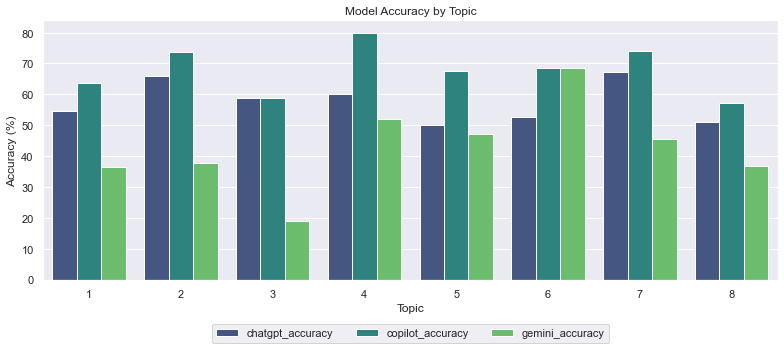

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming LLMData is already defined and contains 'topic', 'answer', 'chatgpt', 'copilot', 'gemini' columns
df = pd.DataFrame(LLMData)

# Calculate accuracy percentage for each model
df['chatgpt_accuracy'] = (df['answer'] == df['chatgpt']) * 100
df['copilot_accuracy'] = (df['answer'] == df['copilot']) * 100
df['gemini_accuracy'] = (df['answer'] == df['gemini']) * 100

# Melt the DataFrame to long format for easier plotting
df_melted = pd.melt(df, id_vars=['topic'], value_vars=['chatgpt_accuracy', 'copilot_accuracy', 'gemini_accuracy'],
                    var_name='model', value_name='accuracy_percentage')

# Plot using Seaborn
plt.figure(figsize=(11, 5))
sns.barplot(x='topic', y='accuracy_percentage', hue='model', data=df_melted, palette='viridis', ci=None)
plt.title('Model Accuracy by Topic')
plt.ylabel('Accuracy (%)')
plt.xlabel('Topic')

plt.legend(
    #title='Model',
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=False, ncol=5
)

plt.tight_layout()
plt.savefig("accuracy-by-topic.svg")
plt.show()


#### Bar plot of distribution of topics per exam set

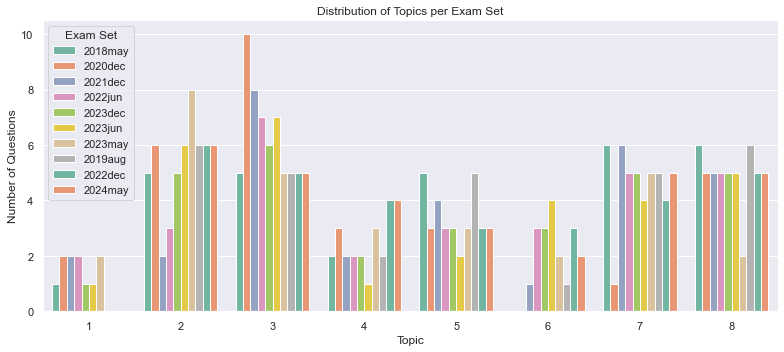

In [10]:
# Count occurrences of each topic per exam set
topic_counts = df.groupby('set')['topic'].value_counts().reset_index(name='count')

# Plot using Seaborn
plt.figure(figsize=(11, 5))
sns.barplot(x='topic', y='count', hue='set', data=topic_counts, palette='Set2')

plt.title('Distribution of Topics per Exam Set')
plt.ylabel('Number of Questions')
plt.xlabel('Topic')

plt.legend(title='Exam Set', loc='upper left')

plt.tight_layout()
plt.savefig("dist-topics-per-exam-set.svg")
plt.show()

### 2.2 Data analysis

#### Retention metric

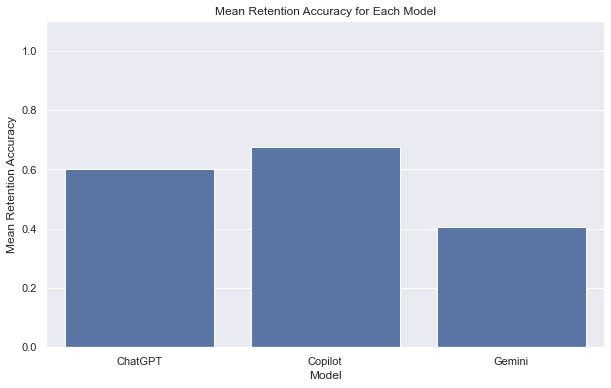

[0.6024464285714285, 0.6746002886002886, 0.405446608946609]

In [11]:
# Function to calculate retention accuracy per set and exercise
def calculate_retention_accuracy(df, model_name):
    accuracy_scores = []

    # Group by 'set' (exam sets)
    grouped_by_set = df.groupby('set')

    for name, group in grouped_by_set:
        # Group by 'exercise' within the current exam set
        grouped_by_exercise = group.groupby('exercise')

        for exercise_name, exercise_group in grouped_by_exercise:
            correct_answers = exercise_group['answer'].tolist()
            model_answers = exercise_group[model_name].tolist()

            # Calculate accuracy for this exercise
            correct_count = sum(1 for x, y in zip(correct_answers, model_answers) if x == y)
            exercise_accuracy = correct_count / len(correct_answers)
            accuracy_scores.append((name, exercise_name, exercise_accuracy))

    return accuracy_scores

# Calculate retention accuracy for each LLM
chatgpt_accuracy = calculate_retention_accuracy(df, 'chatgpt')
copilot_accuracy = calculate_retention_accuracy(df, 'copilot')
gemini_accuracy = calculate_retention_accuracy(df, 'gemini')

# Function to calculate mean retention accuracy
def calculate_mean_accuracy(scores):
    accuracy_per_set = {}
    for score in scores:
        set_name, _, accuracy = score
        if set_name not in accuracy_per_set:
            accuracy_per_set[set_name] = []
        accuracy_per_set[set_name].append(accuracy)

    mean_accuracy = {set_name: sum(acc_scores) / len(acc_scores) for set_name, acc_scores in accuracy_per_set.items()}
    return mean_accuracy

# Calculate mean retention accuracy for each model
chatgpt_mean_accuracy = calculate_mean_accuracy(chatgpt_accuracy)
copilot_mean_accuracy = calculate_mean_accuracy(copilot_accuracy)
gemini_mean_accuracy = calculate_mean_accuracy(gemini_accuracy)

# Plotting mean retention accuracy using Seaborn
models = ['ChatGPT', 'Copilot', 'Gemini']
mean_scores = [
    sum(chatgpt_mean_accuracy.values()) / len(chatgpt_mean_accuracy),
    sum(copilot_mean_accuracy.values()) / len(copilot_mean_accuracy),
    sum(gemini_mean_accuracy.values()) / len(gemini_mean_accuracy)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mean_scores)
plt.title('Mean Retention Accuracy for Each Model')
plt.xlabel('Model')
plt.ylabel('Mean Retention Accuracy')
plt.ylim(0, 1.1)  # Ensure y-axis starts from 0 to 1.1
plt.savefig("mean-retention-accuracy.svg")
plt.show()

mean_scores

#### Hypothetis test cochrans Q


In [12]:
correct = pd.DataFrame()
# Calculate correctness for each model

correct['chatgpt_correct'] = (LLMData['chatgpt'] == LLMData['answer']).astype(int)
correct['copilot_correct'] = (LLMData['copilot'] == LLMData['answer']).astype(int)
correct['gemini_correct'] = (LLMData['gemini'] == LLMData['answer']).astype(int)

correct

,chatgpt_correct,copilot_correct,gemini_correct
0,0,1,0
1,0,0,0
2,0,0,0
3,1,1,1
4,1,1,0
...,...,...,...
295,0,0,0
296,1,1,1
297,1,1,0
298,1,0,0


In [13]:
import numpy as np
from mlxtend.evaluate import cochrans_q
from mlxtend.evaluate import mcnemar, mcnemar_table

y_true = np.ones(300)

q, p_value = cochrans_q(y_true,
                        correct['chatgpt_correct'].to_numpy(),
                        correct['copilot_correct'].to_numpy(),
                        correct['gemini_correct'].to_numpy())

print('Q: %.3f' % q)
print('p-value: %.20f' % p_value)

Q: 59.372
p-value: 0.00000000000012807374


#### Hypothethis POST_HOC test (MCNemars)

In [15]:
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests

# Assuming 'correct' is your DataFrame and it's already defined
# correct = pd.DataFrame( ... )

# Assuming 'y_true' is your true labels and it's already defined
# y_true = ...

# Define the model pairs for pairwise comparison
model_pairs = [
    ('gemini_correct', 'chatgpt_correct'),
    ('copilot_correct', 'chatgpt_correct'),
    ('copilot_correct', 'gemini_correct')
]

# Calculate the p-values using McNemar's test for each pair
p_values = []
for model1, model2 in model_pairs:
    contingency_table = pd.crosstab(correct[model1], correct[model2])
    result = mcnemar(contingency_table, exact=False)
    p_values.append(result.pvalue)

# Apply Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(p_values, method='holm')

# Print the corrected p-values
for pair, pval in zip(model_pairs, pvals_corrected):
    print(f"Corrected p-value for {pair[0]} vs {pair[1]}: {pval}")


Corrected p-value for gemini_correct vs chatgpt_correct: 1.7353486717400154e-06
Corrected p-value for copilot_correct vs chatgpt_correct: 0.019172484755223134
Corrected p-value for copilot_correct vs gemini_correct: 1.5119280677272549e-12


#### Confidence intervals

In [16]:
import dtuimldmtools

# Binarization of answers
preds_chatgpt = (LLMData['chatgpt'] == df['answer']).astype(int).to_numpy()
preds_copilot = (LLMData['copilot'] == df['answer']).astype(int).to_numpy()
preds_gemini = (LLMData['gemini'] == df['answer']).astype(int).to_numpy()

y_true = np.ones(len(df)).astype(int)

(dtuimldmtools.mcnemar(y_true, preds_copilot, preds_chatgpt, alpha=0.05),
dtuimldmtools.mcnemar(y_true, preds_chatgpt, preds_gemini, alpha=0.05),
dtuimldmtools.mcnemar(y_true, preds_copilot, preds_gemini, alpha=0.05))


Result of McNemars test using alpha= 0.05
Comparison matrix n
[[136.  65.]
 [ 40.  59.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.01700030485951798, 0.14930357640515934)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 0.01874091540825797
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[77. 99.]
 [40. 84.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.12252557530937636, 0.26971259370672795)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 5.955419961683012e-07
Result of McNemars test using alpha= 0.05
Comparison matrix n
[[ 93. 108.]
 [ 24.  75.]]
Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] =  (0.21139629104374436, 0.34721905004663656)
p-value for two-sided test A and B have same accuracy (exact binomial test): p= 6.384670989454856e-14


((0.08333333333333333,
  (0.01700030485951798, 0.14930357640515934),
  0.01874091540825797),
 (0.19666666666666666,
  (0.12252557530937636, 0.26971259370672795),
  5.955419961683012e-07),
 (0.28, (0.21139629104374436, 0.34721905004663656), 6.384670989454856e-14))